# Social Media APIs and Marketing

## 1. Measuring engagement with Google Trends

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime, timedelta
from pytrends.request import TrendReq

Let's use our newfound skills with the Google trends API to measure enagagement following a marketing campaign. The company Red Bull spends a large sum of money on its Formula 1 team, in order to market its brand. But it also does lots of other marketing activities. Because most people don't go to the supermarket to buy a Red Bull drink after watching a Formula 1 event, it can be quite tricky to associate sales with different marketing campaigns. But social media allows us to capture consumer reactions and engagement in real time! So if we know that consumer engagement leads to more sales (at least, on the long term), it can be extremely valuable to measure engagement following marketing campaigns.

Our question will be twofold:
1. Does Red Bull create engagement with its Formula 1 expenditures?
2. Does the Pilot matter? I.e., is engagement related to success?

### 1.1: Querying the interest over time

We start by pulling Google trends data for the search term "red bull" between March and yesterday (the Formula 1 season started at the end of March). We also convert our dataframe and ensure the date column is actually seen as a date by `pandas`.

In [3]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["red bull"],timeframe='2021-03-01 2021-11-01')
trends = pytrend.interest_over_time()
trendsdf = pd.DataFrame(data = {'date': trends.index.tolist(),
                                'search': trends["red bull"].tolist()})
trendsdf['date'] = pd.to_datetime(trendsdf['date'])
trendsdf

,date,search
0,2021-03-01,34
1,2021-03-02,38
2,2021-03-03,39
3,2021-03-04,36
4,2021-03-05,36
...,...,...
241,2021-10-28,45
242,2021-10-29,43
243,2021-10-30,50
244,2021-10-31,53


Next, we take a look at the daily search hits (recall that the maximum will always be 100 in any Google Trends query):

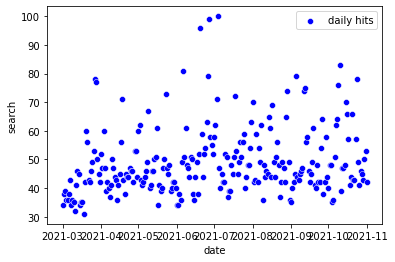

In [4]:
sns.scatterplot( x = 'date',
             y = 'search',
             data = trendsdf,
             label = 'daily hits', color="blue")
plt.show()

### 1.2: Combining it with race data

We have some data on the searches. Now, we can add race data into the mix, but we need to make sure that the dates are actual dates again:

In [5]:
racingdf = pd.read_csv('red_bull_race_results.csv')
racingdf['date'] = pd.to_datetime(racingdf['date'], format="%d.%m.%y")
racingdf

,date,perez,verstappen
0,2021-03-28,5.0,2.0
1,2021-04-18,11.0,1.0
2,2021-05-02,4.0,2.0
3,2021-05-09,5.0,2.0
4,2021-05-23,4.0,1.0
5,2021-06-06,1.0,18.0
6,2021-06-20,3.0,1.0
7,2021-06-27,4.0,1.0
8,2021-07-04,6.0,1.0
9,2021-07-18,16.0,NaN


The dataset gives the positioning of the two Red Bull pilots, Sergio Pérez and Max Verstappen. A missing value indicates that the pilot did not finish the race.

Similar to before, we can merge the two data frames by date, in order to understand whether race day implies a high number of searches. For simplicity, we can take only one extra column of `racingdf`, to see whether the date exists or not.

In [6]:
temp = pd.merge(trendsdf, racingdf[['date','perez']], how='left',on='date')
temp

,date,search,perez
0,2021-03-01,34,NaN
1,2021-03-02,38,NaN
2,2021-03-03,39,NaN
3,2021-03-04,36,NaN
4,2021-03-05,36,NaN
...,...,...,...
241,2021-10-28,45,NaN
242,2021-10-29,43,NaN
243,2021-10-30,50,NaN
244,2021-10-31,53,NaN


Whereever there is a missing value in the `perez` column, there was no race on the day. We can adjust our dataframe accordingly and plot our merged result:

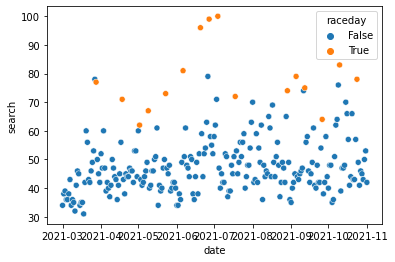

In [7]:
temp['raceday'] = temp['perez'].notna()
sns.scatterplot( x = 'date',
             y = 'search',
             data = temp,
            hue="raceday")
plt.show()

A first look at the data seems to indicate that there is support for the hypothesis that the Formula 1 marketing leads to customer engagement. Of course, more work is needed to establish robust evidence.

### 1.3: Measuring the importance of the pilot

We will turn to the second question instead (whether the pilots matter). For this, we need to first clean the racing dataset.

Since disqualification is often a topic of intense interest in Formula 1, we create an additional column to measure whether a driver has not completed the race.

There is one special case, which requires contextual knowledge: on 2021-06-06, Verstappen did not finish the race and was only placed because he had completed more than 90%. For consistency, we may consider putting a 1 in the column `'verstappen_out'` here (this is a typical case in which you want to check for consistency).

We then remove the `NAs` by replacing them with the worst result (this is of course just one possible choice and requires further analysis).

In [8]:
racingdf['perez_out'] = racingdf['perez'].isna().astype(int)
racingdf['verstappen_out'] = racingdf['verstappen'].isna().astype(int)
racingdf.loc[racingdf['date'] == '2021-06-06','verstappen_out'] = 1
racingdf['perez'] = racingdf['perez'].fillna(racingdf['perez'].max())
racingdf['verstappen'] = racingdf['verstappen'].fillna(racingdf['verstappen'].max())
racingdf

,date,perez,verstappen,perez_out,verstappen_out
0,2021-03-28,5.0,2.0,0,0
1,2021-04-18,11.0,1.0,0,0
2,2021-05-02,4.0,2.0,0,0
3,2021-05-09,5.0,2.0,0,0
4,2021-05-23,4.0,1.0,0,0
5,2021-06-06,1.0,18.0,0,1
6,2021-06-20,3.0,1.0,0,0
7,2021-06-27,4.0,1.0,0,0
8,2021-07-04,6.0,1.0,0,0
9,2021-07-18,16.0,18.0,0,1


Next, we want to find out the engagement around the race days. We create an `"engagement"` column in our `racingdf`. In particular, we go through all the race dates and find the engagement (race day searches relative to average search number in the week - this is our very own definition).

In [9]:
relative_engagement = []
for i in range(len(racingdf)):
    race_date = racingdf.iloc[i,]['date']
    trendsdf['difftime'] = trendsdf['date']-race_date
    trendsdf['difftime'] = [diff.days for diff in trendsdf['difftime']]
    racetrends = trendsdf[abs(trendsdf['difftime']) <= 3]
    if len(racetrends[racetrends['difftime']==0]) > 0:
        relative_engagement.append( racetrends[racetrends['difftime']==0].iloc[0]['search']/np.mean(racetrends['search']) )
    else:
        relative_engagement.append(np.nan)
racingdf['engagement'] = relative_engagement
racingdf

,date,perez,verstappen,perez_out,verstappen_out,engagement
0,2021-03-28,5.0,2.0,0,0,1.368020
1,2021-04-18,11.0,1.0,0,0,1.466077
2,2021-05-02,4.0,2.0,0,0,1.257971
3,2021-05-09,5.0,2.0,0,0,1.408408
4,2021-05-23,4.0,1.0,0,0,1.460000
5,2021-06-06,1.0,18.0,0,1,1.557692
6,2021-06-20,3.0,1.0,0,0,1.723077
7,2021-06-27,4.0,1.0,0,0,1.506522
8,2021-07-04,6.0,1.0,0,0,1.654846
9,2021-07-18,16.0,18.0,0,1,1.388430


Now that we have the data, we can try to see what effects the placements have on engagement. Of course, we also analyze the effect of a driver not finishing the race:

In [10]:
X = racingdf.drop(['date', 'engagement'], axis=1)
Y = racingdf.engagement
X = sm.add_constant(X)
lm = sm.OLS(Y,X).fit()
print (lm.summary()) 

                            OLS Regression Results                            
Dep. Variable:             engagement   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     5.531
Date:                Wed, 03 Nov 2021   Prob (F-statistic):            0.00925
Time:                        18:29:50   Log-Likelihood:                 19.390
No. Observations:                  17   AIC:                            -28.78
Df Residuals:                      12   BIC:                            -24.61
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.8287      0.089     20.

C:\Users\Mattheus\anaconda3\envs\smm750\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## 2. Using Twitter data

It might be useful to also see what users are tweeting about regarding the races. Let's take a look at the Twitter API!

In [11]:
import tweepy
import pickle

With the Twitter API we can access most of Twitter’s functionality from within Python (that means both reading **and** writing Tweets, or finding out about users and trends). The package of choice is *Tweepy*, which deals with all the messy details.

To access the Twitter API, you need to be authenticated. Hence, every request has to come with authentication information. To get this information in the first place, we need to generate our own credentials with a Developer Account:

1. Go to the <a href=https://developer.twitter.com/en>Twitter Developer Site</a> and apply for a Developer Account (you will need a Twitter account for this).
2. Create an application (e.g., "My_first_application"). Credentials and limits are per application, not per account.
3. Once you have created your application, you can transfer your consumer API key and secret, as well as your app access key and secret to the Python code below (see also https://developer.twitter.com/en/docs/basics/authentication/overview/oauth)

You can directly add your data as a string like this:
```
CONSUMER_API_KEY = 'COPY STRING HERE'
CONSUMER_API_SECRET = 'COPY STRING HERE'
ACCESS_KEY = 'COPY STRING HERE'
ACCESS_SECRET = 'COPY STRING HERE'
```

So that I can share my code without everyone using my credentials (which would probably lead to me being blocked by Twitter), I'm instead reading the data from a csv here:

In [12]:
api_access = pd.read_csv('API_access.csv',delimiter=';')
CONSUMER_API_KEY = api_access[api_access['api'] == 'twitter_consumer_api_key']['key'].tolist()[0]
CONSUMER_API_SECRET = api_access[api_access['api'] == 'twitter_consumer_api_secret']['key'].tolist()[0]
ACCESS_KEY = api_access[api_access['api'] == 'twitter_access_key']['key'].tolist()[0]
ACCESS_SECRET = api_access[api_access['api'] == 'twitter_access_secret']['key'].tolist()[0]

FileNotFoundError: [Errno 2] No such file or directory: 'API_access.csv'

We are also not allowed to request too many Tweets at the same time. There are per-day limits, as well as "rate limits" for 15-minute blocks. If you exceed your limits, you **will** get blocked for some time. For detailed information on the limits, check out https://developer.twitter.com/en/docs/twitter-api/v1/tweets/timelines/overview and https://developer.twitter.com/en/docs/rate-limits.
In many cases, we can use the functionality of Tweepy to automatically delay calls in order to wait on the rate limit - but be aware that this doesn't always work, and we may need to manually add timeouts.

We are now ready to create our verified interface (automatically waiting on our rate limit as necessary):

In [13]:
auth = tweepy.OAuthHandler(CONSUMER_API_KEY, CONSUMER_API_SECRET)
auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
api = tweepy.API(auth, wait_on_rate_limit = True)

NameError: name 'CONSUMER_API_KEY' is not defined

Let's download some tweets! Note that the API only allows you to download tweets based on general queries from the past 9 days. If you want to download older tweets, you will need to dowload the tweets of a particular account (see below). For simplicity, we will focus on the last week.

### 2.1: Pulling all tweets based on a search query

Let's search for tweets with the hash tag `"#redbull"`. You can find details about the tweet objects at https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet.

In [ ]:
for tweet in tweepy.Cursor(api.search,q="#redbull",lang="en").items(5):
    print("Created at: " + str(tweet.created_at))
    print("User: " + tweet.user.screen_name)
    print("Followers: " + str(tweet.user.followers_count))
    print("Content: " + tweet.text)
    print("---------------------\n")

When requesting tweets in this manner, the API will cut anything beyond 140 characters. That means, even if we search for tweets with #redbull, the tweet we receive may not contain the hashtag. However, we can add the parameter `tweet_mode='extended'` to our `tweepy.Cursor()` call. In this case, returned tweets no longer have a `.text` attribute, but a `.full_text` attribute

(alternatively, we can "hydrate" tweets at any time, using just their ID (i.e. request the full text). You can thus use only the tweet ID to share your data)

In [ ]:
for tweet in tweepy.Cursor(api.search,q="#redbull",lang="en", tweet_mode='extended').items(5):
    print("Created at: " + str(tweet.created_at))
    print("User: " + tweet.user.screen_name)
    print("Followers: " + str(tweet.user.followers_count))
    print("Content: " + tweet.full_text) # Note: when looking at extended tweets, there is no attribute `.text`
    print("---------------------\n")

We can extend this, to get all tweets of the last week. Note: in principle, the `include_rts=False` option should exclude any retweets. In practice, however, there seems to be some issues in how `tweepy` performs this exclusion. Hence, we make sure manually to only capture original tweets, using the keyworkd `"-filter:retweets"` in our query.

In [ ]:
start_day = datetime.utcnow() - timedelta(days=7)
tweets = []
for tweet in tweepy.Cursor(api.search,q="#redbull -filter:retweets",
                           lang="en",since=str(start_day.date())).items():
    tweets.append(tweet)
len(tweets)

Let's start having a look at Tweeter demographics. Where are tweeters from (we only consider accounts with locations)? Remember, that the <a href="https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet">Developer Platform</a> has all the relevant information about tweet objects.

In [ ]:
tweet = tweets[0]
tweet.user.location

We will consider only locations that have at least 5 tweets emerging from them.

In [ ]:
tweet_loc = [tweet.user.location for tweet in tweets if tweet.user.location != ""]
tweet_loc_df = pd.DataFrame(tweet_loc,columns=['location'])
tweet_loc_df = tweet_loc_df.groupby('location')['location'].count().reset_index(name='count')
tweet_loc_df = tweet_loc_df[tweet_loc_df['count'] >= 5]
tweet_loc_df.sort_values(by='count',ascending=False)

Let's now take a look at when the Tweets where sent.

In [ ]:
tweet = tweets[0]
tweet.created_at.date()

In [ ]:
tweet.created_at.date().day

We can collect the counts per day into a table and plot them:

In [ ]:
tweet_day = [tweet.created_at.date().day for tweet in tweets]
tweet_day_df = pd.DataFrame(tweet_day,columns=['day'])
tweet_day_df = tweet_day_df.groupby('day')['day'].count().reset_index(name='count')
sns.lineplot(y=tweet_day_df['count'], x = tweet_day_df['day'])
plt.show()

Finally, we explore the other hashtags within the tweets:

In [ ]:
tweet = tweets[1]
tweet.entities['hashtags']

There might be multiple hashtags of course, each one is its own dictionary, within a list of dictionaries. In each dictionary, the key `'text'` gives the hashtag and the key `'indices'` gives the position within the tweet.

In [ ]:
tweet.entities['hashtags'][1]['text']

Let's now get all the hashtags from our tweets (except the redbull hashtags). We can convert these into a dataframe, where we count the occurences:

In [ ]:
attached_tags = [tweet.entities['hashtags'] for tweet in tweets if tweet.entities['hashtags'] != []]
attached_tags_cleaned = [hashtag['text'].lower() for tags in attached_tags for hashtag in tags if hashtag['text'].lower() != 'redbull']
hashtag_df = pd.DataFrame(attached_tags_cleaned,columns=['hashtag'])
hashtag_df = hashtag_df.groupby('hashtag')['hashtag'].count().reset_index(name='count')
hashtag_df.sort_values(by='count',ascending=False).head(20)

### 2.2: Finding followers

We now want to learn more about the people (and company accounts) that follow Red Bull (as well as about whom they follow other than Red Bull). Let's start with finding some of Red Bull's followers:

In [ ]:
followers_rb = []
for follower in tweepy.Cursor(api.followers,"redbull").items(5):
    followers_rb.append(follower)

A company like Red Bull has quite some followers and we would run into problems trying to get all at once. But if you really care about collecting everything, the following code times out for 15 minutes after every 3000 names (watch out, this would still run for about 170 hours. It is advisable to check the code in more detail and to add an option for saving lists once in a while):

```
followers_rb = []
users = tweepy.Cursor(api.followers, screen_name=accountvar, count=200).items()
while True:
    try:
        user = next(users)
    except tweepy.TweepError:
        time.sleep(60*15)
        user = next(users)
    except StopIteration:
        break
    followers_rb.append(user.screen_name)
```

Note that followers are saved as "User" objects, with their very own attributes, found here: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/user. The twitter-handle is defined by the `screen_name` attribute.

In [ ]:
follower = followers_rb[0]
follower

In [ ]:
follower = followers_rb[1]
follower.screen_name

Can we get other accounts that this person follows? (Twitter defines those as friends)

In [ ]:
for user in tweepy.Cursor(api.friends, screen_name=follower.screen_name).items(10):
    print(user.screen_name)

Sometimes, the information is set to private, so we don't know who the person is following. Hence, we need to do some Exception management:

In [ ]:
try:
    for user in tweepy.Cursor(api.friends, screen_name=follower.screen_name).items(10):
        print(user.screen_name)
except tweepy.TweepError:
    print("Follower " + follower.screen_name + " does not provide access to their friends.")

Let's combine this for multiple of Red Bull's followers. For the first 5 followers, let's get up 10 of the accounts that they follow each:

In [ ]:
all_followers_friends = []
for follower in followers_rb:
    followers_friends = []
    try:
        for user in tweepy.Cursor(api.friends, screen_name=follower.screen_name).items(10):
            followers_friends.append(user)
    except tweepy.TweepError:
        print("Follower " + follower.screen_name + " does not provide access to their friends.")
    print("Added " + str(len(followers_friends)) + " friends of follower " + follower.screen_name)
    all_followers_friends += followers_friends

In [ ]:
for followers_friend in all_followers_friends:
    print(followers_friend.screen_name)

It's easy to imagine how we could create a network of accounts, right?

### 2.3: Finding a specific user's tweets (over time)

We can also take a look at all the Tweets of a specific account. When looking at an account's Tweets, we do not have to worry about date limits (but there are still restrictions, so let's make sure not to pull too many).

To search an account's Tweets, we can use either the `.screen_name` or the `.id`:

In [ ]:
user = all_followers_friends[0]
user_screen_name = user.screen_name
user_id = user.id
print(user_screen_name)
print(user_id)

In [ ]:
for tweet in tweepy.Cursor(api.user_timeline,id=user_id).items(5):
    print(tweet.text)

In a similar manner, we can get the tweets of Red Bull (by `.id` or `.screen_name`)!

In [ ]:
tweets_rb = []
for tweet in tweepy.Cursor(api.user_timeline,screen_name='redbull').items(100):
    tweets_rb.append(tweet)

In [ ]:
len(tweets_rb)

### 2.4: Back to our engagement measures

Let's try to enrich our `racingdf` using Tweet data.

We can only collect tweets by hashtag for a bit more than a week. Hence, I have prepared a full week of tweets every Wednesday after a Formula 1 race in the last few weeks. This is stored as a `pickle` file - a system that allows to directly save arbitrary Python objects outside of our program. Hence, once we call up the pickle file, we get back exactly the variables we saved into it. Since I saved a list of tweets, the return value from `pickle.load(file)` will be a list of tweets.

In [ ]:
with open('Tweets_210908_211027.txt', 'rb') as file:
    tweets = pickle.load(file)

In [ ]:
len(tweets)

Briefly recall our dataset `racingdf`:

In [ ]:
racingdf

The tweet data only captures the last four races, so we will focus on the dates of those:

In [ ]:
racedates = racingdf.tail(4)['date'].tolist()
racedates

Let's take the first of these race dates, as well as an "arbitrary" tweet and compare dates (don't be surprised, this will lead to an error!)

In [ ]:
racedate = racedates[0]
tweet = tweets[219]
tweet.created_at.date() - racedate

The problem here is that the date objects used by `tweepy` are not the same as the date objects used by `pandas`! Hence, let's convert the tweet's date with `pandas`:

In [ ]:
pd.to_datetime(tweet.created_at.date()) - racedate

We can convert this time difference into days:

In [ ]:
(pd.to_datetime(tweet.created_at.date()) - racedate).days

Ok, the tweet comes from the right day. Let's take a look what it is about:

In [ ]:
tweets[219].text

The name "Verstappen" appears in here. We can, of course, check this automatically with Python (note that we use `.lower()` to avoid issues when comparing different capitalization):

In [ ]:
'verstappen' in tweets[219].text.lower()

We can combine the above code to create two new columns: a count of tweets talking about Perez and a count of tweets talking about Verstappen. We first create an empty column:

In [ ]:
racingdf['tweets_perez'] = 0
racingdf['tweets_verstappen'] = 0

In [ ]:
for racedate in racedates:
    perez_count = 0
    verstappen_count = 0
    for tweet in tweets:
        if (pd.to_datetime(tweet.created_at.date()) - racedate).days in [0,1]:
            if 'perez' in tweet.text.lower():
                perez_count += 1
            if 'verstappen' in tweet.text.lower():
                verstappen_count += 1
    racingdf.loc[racingdf['date'] == racedate,"tweets_perez"] = perez_count
    racingdf.loc[racingdf['date'] == racedate,"tweets_verstappen"] = verstappen_count
racingdf

In [ ]:
reduced_df = racingdf.tail(4)
ax = sns.scatterplot(x=reduced_df.date, y=reduced_df.perez, color = "red")
ax.set_ylabel("perez placement",color="red",fontsize=14)
ax2 = plt.twinx()
sns.scatterplot(x=reduced_df.date, y=reduced_df.tweets_perez, color = "blue")
ax2.set_ylabel("perez tweets",color="blue",fontsize=14)
plt.show()

In [ ]:
reduced_df = racingdf.tail(4)
ax = sns.scatterplot(x=reduced_df.date, y=reduced_df.verstappen, color = "red")
ax.set_ylabel("verstappen placement",color="red",fontsize=14)
ax2 = plt.twinx()
sns.scatterplot(x=reduced_df.date, y=reduced_df.tweets_verstappen, color = "blue")
ax2.set_ylabel("verstappen tweets",color="blue",fontsize=14)
plt.show()

### Discussion point: Can you interpret these results? Why is the number of mentions of Verstappen so high on September 12?




### 2.5 (Exercise): Finding out more about the people talking about Verstappen

**Finding the right tweets and users**

Start by finding all the tweets in which the word `'verstappen'` appears, making sure to eliminate any capitalizaiton issues. Put those tweets into a list `verstappen_tweets`.

Next, find out how many tweets each user made that made any of the `verstappen_tweets`.

One possibile approach is to create a dictionary of tweet-lists, loop through the tweets, and change the dictionary as follows: if the `.user.screen_name` attribute has not appeared before, create a new entry into the dictionary. The attribute is the key and as a value, create a new list with the current tweet inside. If the `.user.screen_name` attribute has appeared before, simply append the current tweet to the corresponding list.

Next, create a list of `active_tweeters` and a list of `inactive_tweeters`. The former list should contain the users with more than one tweet within `verstappen_tweets`.

Note: it will be useful later on if you store the `.user`-objects, not just the `.user.screen_name` attribute.

How many `active_tweeters` are there? How many `inactive_tweeters`?

**Counting followers**

Next, we will take a look at the followers of our different tweeters. For the active (resp. inactive) tweeters, display a histogram showing the number of followers. The relevant user-attribute is `.followers_count`.

The extremely skewed nature of the number of followers makes it difficult to see anything or make comparisons. When we have heavily skewed data, we usually use the logarithm instead. Hence, repeat the plotting exercise with the `np.log()` of the `.followers_count`. Keep in mind that some may have 0 followers, so add a 1 to avoid errors.

Do you see any differences?

**Analyzing highly influential followers**

Next, we will take a look at the `active_tweeters` with more than $10,000$ followers. Create a new list, `selected_accounts`, and store the relevant user-objects within the list.

To understand the type of highly influential followers better, we take a look at the tweets of the `selected_accounts`. In particular, we explore the hashtags that they use.

1. Create a list of hashtags
2. loop through the `selected_accounts`
3. For each user, find the last 100 (complete) tweets they wrote (using `tweepy.Cursor(api.user_timeline,screen_name=user.screen_name, tweet_mode='extended').items(100)` )
4. Within each tweet, collect the list of hashtags (using `.entities['hashtags']`) and append these to our overall list

If you print out the list of hashtags, you'll see that each hashtag is a dictionary with two keys:
1. `'text'`: this gives the actual hashtag
2. `'indices'`: this gives the position of the hashtag within the tweet

Go through the list of hashtags and store only the actual hashtag using key `'text'`

Finally, add the hashtags into a dictionary, together with the number of times they appear (using the function `.groupby()` of your newly created data frame). Sort the dataframe by the occurence.

What types of influential accounts do you think actively post about Red Bull?

Similar to hashtags, we can also find out which users are being mentioned in tweets (the @'s). Repeat the above search, but instead of searching for hashtags, search for the users mentioned with `.entities['user_mentions']`.

The `user_mentions` is another dictionary. This time, it contains the `screen_name` of the mentioned user, the `name` (display name), the `id`, an `id_str` (same as `id` but saved as a string instead of a number), and the `indices` which indicate the position of the mention within the tweet. Go through the list of mentions and pick out the display name (`name`) for each:

As before, create a data frame with a count for how often each mention appears, and display the data frame sorted by count.